This file is a snapshot of my code at it's most recent stage.  I made modifications to it for each experiment and as I worked to collect plots and graphs for my paper.  I have done my best to leave all the code I used in comments that also say what that code was used for, but any use of this code for any specific application will require some level of modification.

Additionally much of the base level of this code is from GA Best in the class-provided Jupyter pages.  

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy
import math

In [882]:
def initilization_of_population(size, initialType, function):
    population = []
    if function == 0: # Himmelblau
        functionRange = 5
    elif function == 1: # Eggholder - not functional
        functionRange = 512
    elif function == 2: # Ackley
        functionRange = 5
    elif function == 3: # Cross-in-tray - not functional
        functionRange = 10
    elif function == 4: # Beale
        functionRange = 4.5

    # random initalization
    if initialType == 0: 
        for i in range(size):
            chromosome = (np.random.rand(2) - 0.5) * 2.0 * functionRange  # randomly pick our +/- numbers
            population.append(chromosome)

    # grid initalization
    elif initialType == 1:
        dimension = int(np.sqrt(size))
        for i in range(dimension):
            for j in range(dimension):
                # set the grid based on function range
                chromosome = (((-1.0 * functionRange) + ((functionRange / (dimension/2)) * i) + (functionRange / dimension)), 
                              ((-1.0 * functionRange) + ((functionRange / (dimension/2)) * j) + (functionRange / dimension)))
                population.append(chromosome)
    return population 


In [883]:
def fitness_score(population, function):
    scores = []
    for chromosome in population:
        # evaluate individuals over proper function
        if function == 0:
            # Himmelblau's function
            score = (chromosome[0]**2 + chromosome[1] - 11)**2 + (chromosome[0] + chromosome[1]**2 - 7)**2
            scores.append( 1.0 / (score + 0.01) ) 
        elif function == 1:
            # Eggholder function - not functional
            term1 = math.sqrt(math.fabs((chromosome[0]/2)+chromosome[1]+47))
            term2 = math.sqrt(math.fabs(chromosome[0]-chromosome[1]+47))
            score = -(chromosome[1]+47)*math.sin(term1)-chromosome[0]*math.sin(term2)
            scores.append(1.0 / (score + 0.01))
        elif function == 2:
            # Ackley function
            term1 = -0.2 * math.sqrt(0.5 * ((chromosome[0] * chromosome[0]) + (chromosome[1] * chromosome[1])))
            term2 = 0.5 * (math.cos(2 * math.pi * chromosome[0]) + math.cos(2 * math.pi * chromosome[1]))
            score = (-20 * math.exp(term1)) - math.exp(term2) + math.e + 20
            scores.append (1.0 / (score + 0.01)) 
        elif function == 3:
            # Cross-in-tray function - not functional
            term1 = (np.sqrt((chromosome[0] * chromosome[0]) + (chromosome[1] * chromosome[1])) / np.pi)
            score = -0.0001 * (np.abs(np.sin(chromosome[0]) * np.sin(chromosome[1]) * np.exp(np.abs(100 - term1)) + 1) ** 0.1)
            scores.append(1.0 / (score + 2.06261)
            )
        elif function == 4:
            # Beale function
            term1 = 1.5 - chromosome[0] + (chromosome[0] * chromosome[1])
            term2 = 2.25 - chromosome[0] + (chromosome[0] * (chromosome[1] ** 2))
            term3 = 2.625 - chromosome[0] + (chromosome[0] * (chromosome[1] ** 3))
            score = (term1 ** 2) + (term2 ** 2) + (term3 ** 2)
            scores.append(1.0 / (score + 0.01))

    scores, pop = np.array(scores), np.array(population.copy())
    inds = np.argsort(scores)
    scores = list(scores[inds][::-1])
    pop = list(pop[inds,:][::-1])
    return scores, pop

In [884]:
def selection(selectionType, scores,pop_after_fit):
    population_nextgen = []
    # elitism
    population_nextgen.append(pop_after_fit[0].copy())
    population_nextgen.append(pop_after_fit[0].copy())

    if (selectionType == 0): # roulette wheel selection
        # pick our remaining parents (so two for each child)
        max_val = np.sum(scores)
        for i in range(1,len(scores)):
            for k in range(2): 
                pick = random.uniform(0, max_val)
                current = 0
                for j in range(len(scores)): 
                    current += scores[j]
                    if current > pick: 
                        break 
                population_nextgen.append(pop_after_fit[j].copy())    
    elif (selectionType == 1): #tournament selection (n = 5)
        n = 5 # can use this to vary tournament pool size
        for i in range(1,2 * len(scores)):
            best = random.randint(0, len(scores)-1)
            for j in range(n-1): # select each pool
                pick = random.randint(0, len(scores)-1)
                if scores[pick] > scores[best]: # run 'tournament'
                    best = pick
            population_nextgen.append(pop_after_fit[best].copy())
    return population_nextgen

In [885]:
def crossover(crossoverType, pop_after_sel,sz):
    population_nextgen = [] 
    # elitism
    population_nextgen.append(pop_after_sel[0].copy())
    
    if(crossoverType == 0): # one-point crossover
        for i in range(1,sz):
            child = pop_after_sel[2*i+0].copy()
            parent2 = pop_after_sel[2*i+1].copy()
            loc = np.random.randint(0,1)
            child[loc] = parent2[loc]
            population_nextgen.append(child)

    elif(crossoverType == 1): #uniform crossover
        for i in range(1,sz):
            child = pop_after_sel[2*i+0].copy()
            parent2 = pop_after_sel[2*i+1].copy()
            for j in range(2): # crossover for each axis separately
                if (np.random.randint(0,1) == 1):
                    child[j] = parent2[j]
            population_nextgen.append(child)
    return population_nextgen

In [886]:
def mutation(function, mutationType, pop_after_cross,mutation_rate,sz):
    if function == 0: # Himmelblau
        functionRange = 5
    elif function == 1: # Eggholder - not functional
        functionRange = 512
    elif function == 2: # Ackley
        functionRange = 5
    elif function == 3: # Cross-in-tray - not functional
        functionRange = 10
    elif function == 4: # Beale
        functionRange = 4.5

    population_nextgen = []
    population_nextgen.append(pop_after_cross[0].copy())
    
    # uniform mutation
    if mutationType == 0:
        for i in range(1,sz): 
            chromosome = pop_after_cross[i].copy()
            for j in range(len(chromosome)): 
                if random.random() < mutation_rate: # based on mutation rate
                    chromosome[j]= ((( np.random.rand() - 0.5 ) * 2.0 ) * functionRange )
            population_nextgen.append(chromosome.copy())

    # modified gaussian mutation
    elif mutationType == 1:
        for i in range(1,sz):
            chromosome = pop_after_cross[i].copy()
            for j in range(len(chromosome)):
                if random.random() < mutation_rate: # based on mutation rate
                    chromosome[j] += np.random.normal(loc=0, scale=functionRange/random.randint(1, 10)) 
                    chromosome[j] = np.clip(chromosome[j], -functionRange, functionRange)
            population_nextgen.append(chromosome.copy())

    return population_nextgen

In [887]:
from tqdm import notebook as tqdm

# main function to run each interation of the algorithm
def generations(function, initialType, selectionType, crossoverType, mutationType, terminationType, stopBound, sz,mutation_rate,n_gen):
    if (terminationType == 0): #generation-based
        totalGen = n_gen
    if (terminationType == 1): #fitness-based
        n_gen = 100000 # this will present an infinite loop
        totalGen = 0
    best_chromo = []
    best_score = []
    population_nextgen = initilization_of_population(sz, initialType, function)
    stats_min = np.zeros(n_gen)
    stats_avg = np.zeros(n_gen)
    stats_max = np.zeros(n_gen)

    # lets store the points from generation to generation
    stored_points = []
    # this is the number of generations
    # for i in tqdm.tqdm(range(n_gen)):
    for i in range(n_gen):
        # evaluate
        scores, pop_after_fit = fitness_score(population_nextgen, function)
        # select
        pop_sel = selection(selectionType, scores,pop_after_fit)
        # crossover
        pop_after_cross = crossover(crossoverType, pop_sel,sz)
        # mutation
        population_nextgen = mutation(function, mutationType, pop_after_cross,mutation_rate,sz)
        scores, pop_after_fit = fitness_score(population_nextgen, function)
        stored_points.append( pop_after_fit ) # remember each epoch
        best_chromo.append(pop_after_fit[0].copy())
        best_score.append(scores[0].copy())        
        stats_min[i] = np.min(scores)
        stats_max[i] = np.amax(scores)
        stats_avg[i] = np.mean(scores)

        if (terminationType == 1): #fitness-based termination
            totalGen += 1
            bestResult = (1 / scores[0]) - 0.01
            if ((bestResult > (-1.0 * stopBound)) & (bestResult < stopBound)): # evaluate if we've reached the stop bound
                break        
    return best_chromo,best_score,stats_min,stats_avg,stats_max,stored_points,totalGen

# Settings
### Test Function
0 = Himmelblau Function


1 = Eggholder Function - not functional


2 = Ackley Function


3 = Cross-in-tray Function - not functional


4 = Beale Function

In [888]:
function = 4

### Initialization

0 = Random Initialization


1 = Grid Initialization

In [889]:
initialType = 1

### Selection
0 = Roulette Wheel Selection


1 = Tournament Selection (n=5)

In [890]:
selectionType = 0

### Crossover
0 = 1-point crossover


1 = Uniform crossover

In [891]:
crossoverType = 0

### Mutation

0 = Uniform Random Mutation


1 = Gaussian Random Mutation

In [892]:
mutationType = 1
mutationRate = 0.2

### Termination
0 = Generation-based Termination

1 = Fitness-based Termination

In [893]:
terminationType = 1
ngen = 500 # if using n-generations termination

# for fitness-based termination
if (function == 0):
    stopBound = 0.0001
if (function == 2):
    stopBound = 0.004
if (function == 4):
    stopBound = 0.003

In [894]:
# this helps run GAs many times and get averages from the results
def gaFull(init, select, cross, mutate, termination):
    initialType=init 
    selectionType=select
    crossoverType = cross
    mutationType = mutate
    terminationType = termination 
    s = 100 # number of individuals
    timesToRun = 200 #here we set how many times we run the GA
    results = []
    minResults = []
    avgResults = []
    maxResults = []
    genResults = []
    for i in range(timesToRun):
        chromo,score,stats_min,stats_avg,stats_max,stored_points,totalGen=generations(function, initialType, selectionType, crossoverType, mutationType, terminationType, stopBound,
        sz=s,mutation_rate=mutationRate,n_gen=ngen)
        results.append(score)
        
        if terminationType == 0: # generation-based
            minResults.append(stats_min)
            avgResults.append(stats_avg)
            maxResults.append(stats_max)

        if terminationType == 1: #fitness-based         
            minResults.append(stats_min[totalGen-1])
            avgResults.append(stats_avg[totalGen-1])
            maxResults.append(stats_max[totalGen-1])

        genResults.append(totalGen)


    if  terminationType == 0: # generation-based
        mean = np.mean(results, axis=0)
        std = np.std(results, axis=0)
        minMean = np.mean(minResults, axis=0)
        minStd = np.std(minResults, axis=0)
        avgMean = np.mean(avgResults, axis=0)
        avgStd = np.std(avgResults, axis=0)

        # experiment 2
        # print(str(np.mean(genResults)) + " " + str(np.std(genResults)) + ", " + str(minMean[-1]) + " " + str(minStd[-1]) + ", " + str(avgMean[-1]) + " " + str(avgStd[-1]) + ", " + str(mean[-1]) + " " + str(std[-1]))
        
        return str(round(mean[-1],3)), str(round(std[-1],3))

    elif terminationType == 1: # fitness-based
        mean = np.mean(genResults)
        std = np.std(genResults)
        minMean = np.mean(minResults)
        minStd = np.std(minResults)
        avgMean = np.mean(avgResults)
        avgStd = np.std(avgResults)
        maxMean = np.mean(maxResults)
        maxStd = np.std(maxResults)

        # experiment 2
        # print(str(mean) + " " + str(std) + ", " + str(minMean) + " " + str(minStd) + ", " + str(avgMean) + " " + str(avgStd) + ", " + str(maxMean) + " " + str(maxStd))
        
        return str(round(mean,3)), str(round(std,3))


    # plot the mean and standard deviation
    plt.plot(range(totalGen), mean[:totalGen], 'g')
    plt.fill_between(range(totalGen), mean[:totalGen] - std, mean[:totalGen] + std, color='lightgreen')
    plt.plot(range(totalGen), avgMean[:totalGen], 'b')
    plt.fill_between(range(totalGen), avgMean[:totalGen] - avgStd, avgMean[:totalGen] + avgStd, color='lightblue')
    plt.plot(range(totalGen), minMean[:totalGen], 'r')
    plt.fill_between(range(totalGen), minMean[:totalGen] - minStd, minMean[:totalGen] + minStd, color='pink')
    plt.ylabel('accuracy')
    plt.xlabel('generations')
    plt.show()

    # plot the statistics
    # plt.plot(range(totalGen), stats_min[:totalGen], 'r')
    # plt.plot(range(totalGen), stats_avg[:totalGen], 'b')
    # plt.plot(range(totalGen), stats_max[:totalGen], 'g')
    # plt.ylabel('accuracy')
    # plt.xlabel('generations')
    # plt.show()

### Experiment 1


In [895]:
# counter = 1
# results = []
# result = []
# # run for each GA combination
# for t in range(2):
#     for m in range(2):
#         for c in range(2):
#             for s in range(2):
#                 for i in range(2):
#                     for f in range(0, 5, 2): # run for each test function
#                         function = f
#                         results.append(gaFull(i,s,c,m,t))
#                     print("GA" + str(counter) + " (" + str(i) + "," + str(s) + "," + str(c) + "," + str(m) + "," + str(t) + ")& " + results[0][0] + " (" + results[0][1] + ")&" + results[1][0] + " (" + results[1][1] + ")&" + results[2][0] + " (" + results[2][1] + ")\\\\")
#                     counter+=1
#                     results.clear()
                

### Experiment 2

In [896]:
# results = []
# counter = 1
# # run for each GA combination
# for t in range(2):
#     for m in range(2):
#         for c in range(2):
#             for s in range(2):
#                 for i in range(2):
#                     print("GA" + str(counter) + " (" + str(i) + "," + str(s) + "," + str(c) + "," + str(m) + "," + str(t) + ")")
#                     counter+=1
#                     gaFull(i,s,c,m,t)

### Experiment 3

In [897]:
for r in range(10):
    mutationRate = r/10 + .05 # set up the range of tested values
    results = gaFull(1, 0, 0, 1, 1)
    print(str(mutationRate) + ": " + str(results))

0.01: ('550.9', '492.093')
0.03: ('177.2', '224.254')
0.05: ('98.38', '108.244')
0.06999999999999999: ('97.84', '124.642')
0.09: ('75.22', '79.76')
0.11: ('39.72', '43.106')
0.13: ('41.62', '49.897')
0.15000000000000002: ('24.06', '28.11')
0.17: ('25.14', '28.254')
0.19: ('24.88', '27.185')
0.21000000000000002: ('16.86', '21.065')
0.23: ('21.02', '22.076')
0.25: ('17.78', '18.499')
0.27: ('16.4', '14.926')
0.29000000000000004: ('14.08', '11.513')
0.31: ('11.52', '13.1')
0.33: ('10.1', '12.08')
0.35000000000000003: ('11.14', '11.25')
0.37: ('9.62', '9.393')
0.39: ('8.5', '8.053')
0.41000000000000003: ('7.72', '8.786')
0.43: ('7.72', '6.296')
0.45: ('8.68', '8.837')
0.47000000000000003: ('7.28', '6.02')
0.49: ('6.22', '5.714')
0.51: ('8.2', '7.754')
0.53: ('5.94', '4.375')
0.55: ('7.04', '4.516')
0.5700000000000001: ('7.26', '5.799')
0.59: ('6.22', '4.197')
0.61: ('6.64', '5.241')
0.63: ('6.52', '5.971')
0.65: ('6.76', '4.585')
0.67: ('7.02', '4.077')
0.6900000000000001: ('6.8', '4.499')

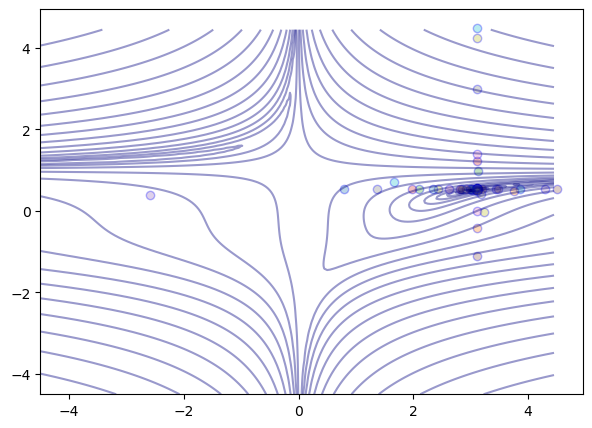

In [898]:
# used for creating plots of GA behavior
from IPython import display
import pylab as pl
from matplotlib.patches import Ellipse
from sklearn import datasets
import numpy as np
import time
from sklearn import datasets

def my_func(x, y):
    if (function == 0):
        z = (x*x + y - 11)**2 + (x + y*y - 7)**2
    elif (function == 1):
        term1 = np.sqrt(abs((x/2)+y+47))
        term2 = np.sqrt(abs(x-y+47))
        z = -(y+47)*np.sin(term1)-x*np.sin(term2)
    elif (function == 2):
        term1 = -0.2 * np.sqrt(0.5 * ((x * x) + (y * y)))
        term2 = 0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))
        z = (-20 * np.exp(term1)) - np.exp(term2) + np.e + 20
    elif (function == 3):
        term1 = (np.sqrt((x * x) + (y * y)) / np.pi)
        z = -0.0001 * (np.abs(np.sin(x) * np.sin(y) * np.exp(np.abs(100 - term1)) + 1) ** 0.1)
    elif (function == 4):
        term1 = 1.5 - x + (x * y)
        term2 = 2.25 - x + (x * (y ** 2))
        term3 = 2.625 - x + (x * (y ** 3))
        z = (term1 ** 2) + (term2 ** 2) + (term3 ** 2)
    return z
        

fig, ax = pl.subplots(nrows = 1, ncols = 1, figsize=(7, 5))
lb = 0
rb = 0
if (function == 0):
    lb = -5
    rb = 5
elif (function == 1):
    lb = -512
    rb = 512
elif (function == 2):
    lb = -5
    rb = 5
elif (function == 3):
    lb = -10
    rb = 10
elif (function == 4):
    lb = -4.5
    rb = 4.5

for t in range(len(stored_points)):    
    
    pl.clf() 
        
    # get this set of points out
    data = stored_points[t] 
    
    # plot  
    for i in range(len(data)):
        pl.scatter(data[i][0], data[i][1], edgecolor='b', alpha=0.3)  
        
    # Himmelblau
    if (function == 0):
        a = np.arange(lb, rb, 0.05)
        b = np.arange(lb, rb, 0.05)
        x, y = np.meshgrid(a, b)
        z = my_func(x, y)
        pl.contour(x, y, z, levels=np.logspace(-9, 9, 50), cmap='jet', alpha=0.4)  

    elif (function == 2):
        a = np.arange(lb, rb, 0.05)
        b = np.arange(lb, rb, 0.05)
        x, y = np.meshgrid(a, b)
        z = my_func(x, y)
        pl.contour(x, y, z, cmap='jet', alpha=0.4) 

    elif (function == 3):
        a = np.arange(lb, rb, 0.05)
        b = np.arange(lb, rb, 0.05)
        x, y = np.meshgrid(a, b)
        z = my_func(x, y)
        pl.contour(x, y, z, cmap='jet', alpha=0.4) 

    elif (function == 4):
        a = np.arange(lb, rb, 0.05)
        b = np.arange(lb, rb, 0.05)
        x, y = np.meshgrid(a, b)
        z = my_func(x, y)
        pl.contour(x, y, z, levels=np.logspace(-9, 9, 50), cmap='jet', alpha=0.4)  
    
    # animation, so pause it!
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.xlim(lb, rb)
    plt.ylim(lb, rb) 
    time.sleep(3)     